In [77]:
!pip install faker
!pip install tqdm

In [78]:
import sys
import requests
import tarfile
import json
import numpy as np
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt

import random
from tqdm import tqdm

from faker import Faker
import re
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import CSVLogger

# Laden der Daten

In [79]:
def Download(fname):
  url = 'https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/' + fname

  r = requests.get(url)
  open(fname , 'wb').write(r.content)
  print("Geladen")
  # Extracting the dataset
  tar = tarfile.open(fname)
  tar.extractall()
  tar.close()

In [80]:
fname = 'examples.tar.gz'
Download(fname)

Geladen


In [81]:
fname = 'labels.tar.gz'
Download(fname)

Geladen


In [82]:
fname = 'val.tar.gz'
Download(fname)

Geladen


In [83]:
#fname = 'train-0.tar.gz'
#Download(fname)

In [84]:
#fname = 'train-1.tar.gz'
#Download(fname)

In [85]:
# Parse the JSON file and read all the images and labels
with open('publaynet/val.json', 'r') as fp:
    samples = json.load(fp)
# Index images
images = {}
for image in samples['images']:
    images[image['id']] = {'file_name': "publaynet/val/" + image['file_name'], 'annotations': []}
for ann in samples['annotations']:
    images[ann['image_id']]['annotations'].append(ann)



In [86]:
# Function to viz the annotation
def markup(image, annotations):
    ''' Draws the segmentation, bounding box, and label of each annotation
    '''
    draw = ImageDraw.Draw(image, 'RGBA')
    for annotation in annotations:
        # Draw bbox
        # "bbox": [37.59, 433.64, 251.07, 20.38]
      tempImage = image.crop((annotation['bbox'][0],
            annotation['bbox'][1],
            annotation['bbox'][0] + annotation['bbox'][2],
            annotation['bbox'][1] + annotation['bbox'][3]))
      tempImage = tempImage.resize((120,120))
      Kategorie = outline=samples['categories'][annotation['category_id'] - 1]['id']
    return np.array(tempImage), np.array(Kategorie)

In [87]:
def createZielDaten(Number):
  Ziel = []
  for i in range(0,6):
    Ziel.append(0)
  Ziel[Number] = 1
  return Ziel

# Vorbereitung fürs Netz

In [88]:
# text ("1"), title ("2"), list ("3"), table ("4"), figure ("5").
# "bbox": [37.59, 360.34, 251.07, 41.36]

x = []
y = []

# Ausschneiden und ausgeben
for i, (_, image) in enumerate(images.items()):
  try:
    with Image.open(image['file_name']) as img:
      TempImage, Kategorie = markup(img, image['annotations'])
      x.append(TempImage)
      y.append(Kategorie)
  except Exception:
    continue

temp_Zieldaten = y
y = []

for i in temp_Zieldaten:
  y.append(createZielDaten(i))

x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)

(11245, 120, 120, 3)
(11245, 6)


# Bau des Models

In [89]:
x = np.array(x)
y = np.array(y)

Wir haben 5 verschiedene Kategorien:

1.   title
2.   text
3.   figure
4.   tabel
5.   list


In [90]:
input = keras.layers.Input((120,120,3))

CNN = keras.layers.Conv2D(60, (2,2) , activation='relu')(input)
CNN = keras.layers.MaxPooling2D((2,2))(input)
CNN = keras.layers.Conv2D(64, (3,3), activation='relu')(CNN)
CNN = keras.layers.MaxPooling2D((2,2))(CNN)
CNN = keras.layers.Conv2D(32, (3,3), activation='relu')(CNN)

Wertung = keras.layers.Flatten()(CNN)
Wertung = keras.layers.Dense(64, activation='relu')(Wertung)

Output = keras.layers.Dense((6), activation = 'sigmoid')(Wertung)


model = keras.models.Model(input, Output)

model.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

# Training


In [91]:
csv_logger = CSVLogger('log.csv', append=True, separator=';')

history = model.fit(x, y, epochs=16, validation_split=0.3, callbacks=[csv_logger])

model.save('model')

Epoch 1/16
246/246 [==============================] - 54s 219ms/step - loss: 0.7635 - accuracy: 0.7632 - val_loss: 0.6420 - val_accuracy: 0.4111
Epoch 2/16
246/246 [==============================] - 54s 219ms/step - loss: 0.1351 - accuracy: 0.8453 - val_loss: 0.8538 - val_accuracy: 0.4348
Epoch 3/16
246/246 [==============================] - 54s 221ms/step - loss: 0.1270 - accuracy: 0.8644 - val_loss: 1.0801 - val_accuracy: 0.4235
Epoch 4/16
246/246 [==============================] - 55s 224ms/step - loss: 0.1242 - accuracy: 0.8714 - val_loss: 0.9390 - val_accuracy: 0.4336
Epoch 5/16
246/246 [==============================] - 54s 221ms/step - loss: 0.1196 - accuracy: 0.8724 - val_loss: 0.4377 - val_accuracy: 0.4244
Epoch 6/16
246/246 [==============================] - 54s 220ms/step - loss: 0.1245 - accuracy: 0.8702 - val_loss: 0.9566 - val_accuracy: 0.4321
Epoch 7/16
246/246 [==============================] - 55s 223ms/step - loss: 0.1107 - accuracy: 0.8749 - val_loss: 0.7081 - val_ac

In [92]:
#from google.colab import files

#files.download('log.csv')

# Auswertung


In [93]:
plt.xkcd()

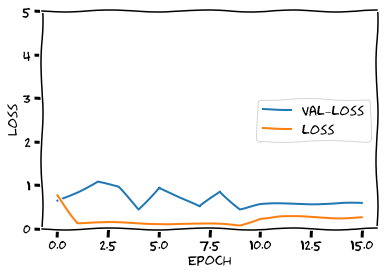

In [94]:
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.plot(history.history['loss'], label = 'loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 5])
plt.legend(loc='center right')
plt.show()

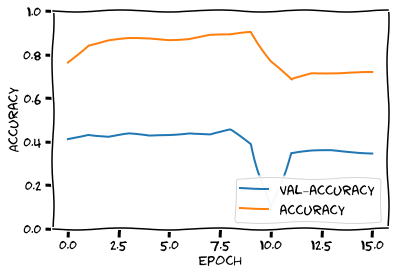

In [95]:
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['accuracy'], label = 'accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# Analyse

In [96]:
#fname = 'val.tar.gz'
#Download(fname)

In [97]:
# Parse the JSON file and read all the images and labels
with open('examples/samples.json', 'r') as fp:
    samples = json.load(fp)
# Index images
images = {}
for image in samples['images']:
    images[image['id']] = {'file_name': "examples/" + image['file_name'], 'annotations': []}
for ann in samples['annotations']:
    images[ann['image_id']]['annotations'].append(ann)

x = []
y = []

# Ausschneiden und ausgeben
for i, (_, image) in enumerate(images.items()):
    with Image.open(image['file_name']) as img:
      TempImage, Kategorie = markup(img, image['annotations'])
      # x.append(TempImage[:, :, 0])
      x.append(TempImage)
      y.append(Kategorie)


x = np.array(x)
y = np.array(y)

print(x.shape)
print(y.shape)

(20, 120, 120, 3)
(20,)


In [98]:
Ergebnis = []
prediction = model.predict(x)

for i in range(len(prediction)):
  maxWert = 0
  Stelle = 0
  for b in range(len(prediction[0])):
    if(prediction[i][b] > maxWert):
      Stelle = b
      maxWert = prediction[i][b]

  Ergebnis.append(Stelle)

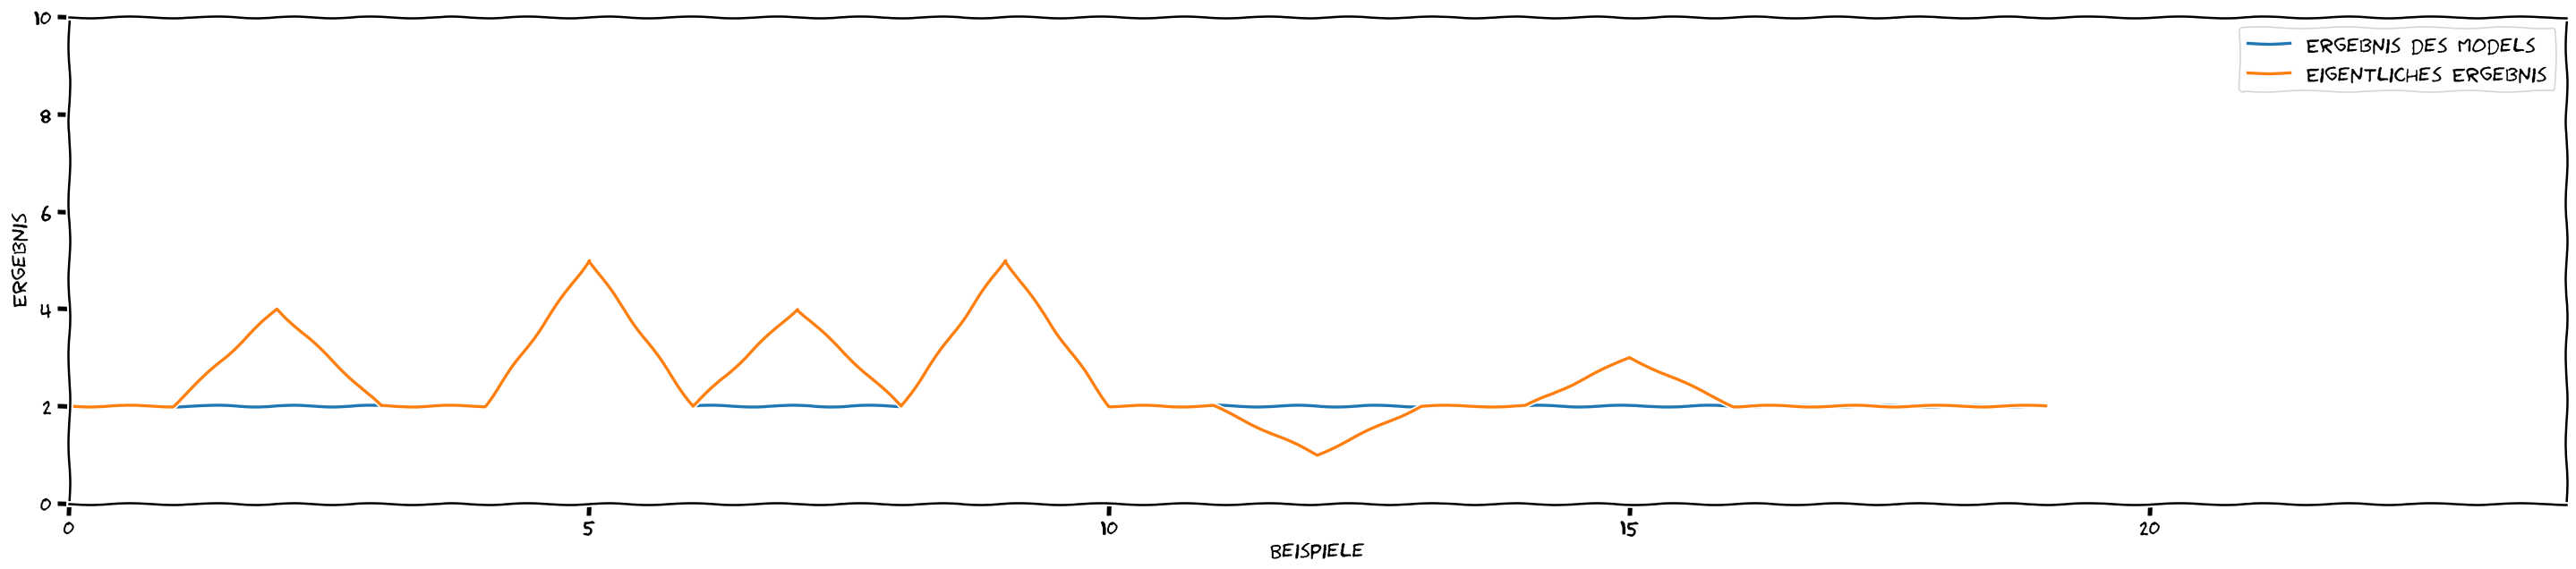

In [99]:
plt.figure(num=None, figsize=(30, 6), dpi=120, facecolor='w', edgecolor='k')
plt.plot(Ergebnis, label = 'Ergebnis des Models')
plt.plot(y, label ='Eigentliches Ergebnis')

plt.xlabel('Beispiele')
plt.ylabel('Ergebnis')
plt.ylim([0, 10])
plt.xlim([0, len(x)+4])
plt.legend(loc='upper right')
plt.show()

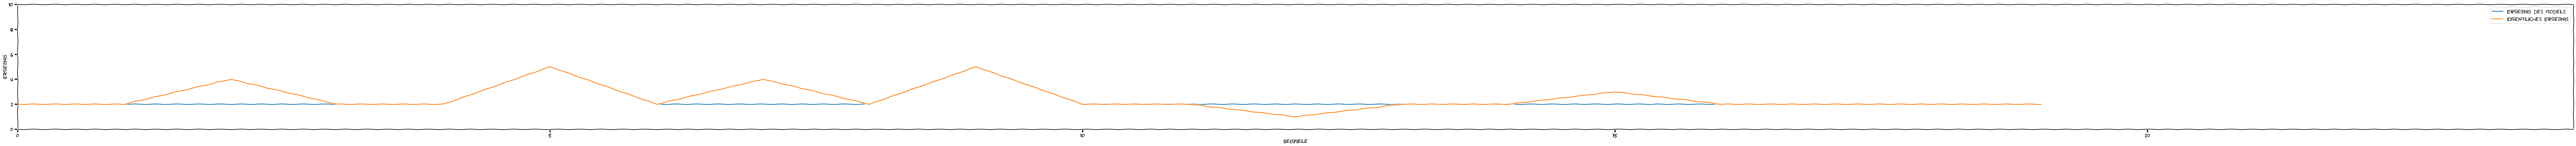

In [100]:
plt.figure(num=None, figsize=(120, 6), dpi=120, facecolor='w', edgecolor='k')

plt.plot(Ergebnis, label = 'Ergebnis des Models')
plt.plot(y, label ='Eigentliches Ergebnis')

plt.xlabel('Beispiele')
plt.ylabel('Ergebnis')
plt.ylim([0, 10])
plt.xlim([0, len(x)+4])
plt.legend(loc='upper right')
plt.show()